## GAN Generator in Action

In this notebook we are going to use a pre-trained GAN to generate new images. For that cause, only the generator network of the GAN is required (not the discriminator).

The generator model in the GAN architecture takes a point from the latent space as input and generates a new image. The latent space itself has no meaning. Through training, the generator learns to map points into the latent space with specific output images and this mapping will be different each time the model is trained.

Typically, new images are generated using random points in the latent space.

This notebook is meant to be visited after you run and understand notebook `01`.

#### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from numpy.linalg import norm
import pathlib

# Get cpu, gpu or mps device for training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


#### Hyperparameters

In [15]:
img_size = 64 
img_channels = 1 #3 
z_dim = 100 
feat_gen = 64 

# path to pre-trained model, change as needed with your own path
load_path = './models/dcgan_fashion_mnist/dcgan_fashion_mnist-2.pt'

#### Generator Architecture

Needs to be the same as the one that was used for the training.

In [16]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_channels, features_g):
        super(Generator, self).__init__()

        self.conv1 = nn.ConvTranspose2d(z_dim, features_g * 8, kernel_size=4, stride=1, padding=0, bias=False)
        self.conv2 = nn.ConvTranspose2d( features_g * 8, features_g * 4, 4, 2, 1, bias=False)
        self.conv3 = nn.ConvTranspose2d( features_g * 4, features_g * 2, 4, 2, 1, bias=False)
        self.conv4 = nn.ConvTranspose2d( features_g * 2, features_g, 4, 2, 1, bias=False)
        self.conv5 = nn.ConvTranspose2d( features_g, img_channels, 4, 2, 1, bias=False)

        self.bn1 = nn.BatchNorm2d(features_g * 8)
        self.bn2 = nn.BatchNorm2d(features_g * 4)
        self.bn3 = nn.BatchNorm2d(features_g * 2)
        self.bn4 = nn.BatchNorm2d(features_g)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = F.tanh(self.conv5(x)) # tanh activation outputs [-1,1]
        return x

Now load the generator to our device and instantiate it with our saved weights:

In [17]:
gen = Generator(z_dim, img_channels, feat_gen).to(device)
checkpoint = torch.load(load_path, map_location=torch.device(device))
gen.load_state_dict(checkpoint['generator'])
gen.eval()

Generator(
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv5): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

#### Unitility Functions for Visualisation

In [ ]:
def denorm(x):
    """Convert [-1,1] range to [0,1] for visualization."""
    return (x * 0.5) + 0.5  # Scale to [0,1]

def generate_image(latent_vector, title="Generated Image"):
    """Generate and visualize an image from a latent vector."""
    with torch.no_grad():
        image_tensor = gen(latent_vector).squeeze(0)  # Remove batch dimension
        image_np = denorm(image_tensor).cpu().numpy().transpose(1, 2, 0)  # Convert (C, H, W) → (H, W, C)

    plt.figure(figsize=(3, 3))
    plt.axis("off")
    plt.title(title)
    plt.imshow(image_np, cmap="gray") # use the "gray" colormap for 1-channel images | remove if working with RGB
    plt.show()

def generate_grid(num_images=64, title="Generated Images"):
    """Generate a grid of images."""
    fixed_noise = torch.randn(num_images, z_dim, 1, 1, device=device)
    
    with torch.no_grad():
        fake_images = gen(fixed_noise).cpu()

    img_grid = vutils.make_grid(fake_images, padding=2, normalize=True).cpu()
    img_np = np.transpose(img_grid.numpy(), (1, 2, 0))  # Convert (C, H, W) → (H, W, C)

    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(title)
    plt.imshow(img_np)
    plt.show()


#### Forward pass through our generator

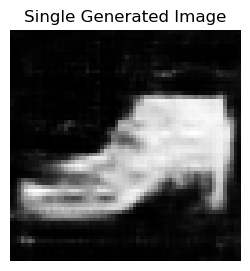

In [19]:
# Create a random latent vector and pass it through the generator to get an image.
random_latent_vector = torch.randn(1, z_dim, 1, 1).to(device)
generate_image(random_latent_vector, title="Single Generated Image")

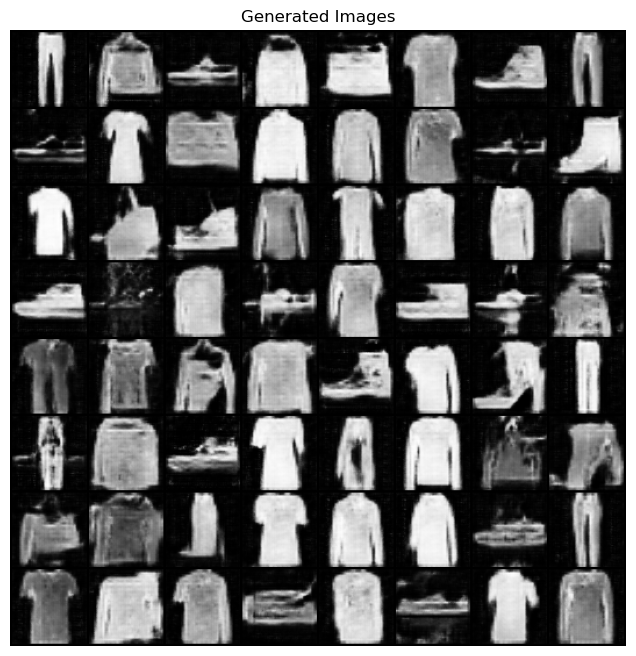

In [7]:
generate_grid()

#### Latent Space Arithmetic

In the following cell, we visualise two images generated from two random latent vectors. 

The points in the latent space can be kept and used in simple vector arithmetic to create new points in the latent space that, in turn, can be used to generate images. This allows for a targeted generation of images.

In the [2015 paper by A. Radford et al.](https://arxiv.org/pdf/1511.06434.pdf), the authors while exploring the latent space for GANs, they demonstrated the vector arithmetic with faces. For example, a face of a smiling woman minus the face of a neutral woman plus the face of a neutral man resulted in the face of a smiling man.

`smiling woman - neutral woman + neutral man = smiling man`

Note that this is admittedly a rather problematic, heteronormative way of demonstrating the way one can navigate in the latent space.

So beyond the use of human faces and identities, starting from the two random vectors below, can you imagine how you could perform vector arithmetic with them, i.e. add them, substract them, multiply them, e.t.c.?

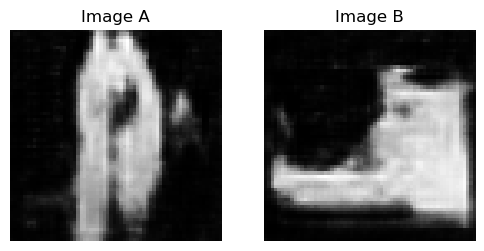

In [21]:
with torch.no_grad():
    l_a = torch.randn(1, z_dim, 1, 1).to(device)
    img_tensor_a = gen(l_a).squeeze(0)  # Remove batch dimension
    img_a = TF.to_pil_image(denorm(img_tensor_a).clamp(0, 1))  # Fix: Denormalize before conversion

    l_b = torch.randn(1, z_dim, 1, 1).to(device)
    img_tensor_b = gen(l_b).squeeze(0)
    img_b = TF.to_pil_image(denorm(img_tensor_b).clamp(0, 1))  # Fix: Denormalize before conversion

plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Image A")
plt.imshow(img_a, cmap="gray") 

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Image B")
plt.imshow(img_b, cmap="gray")

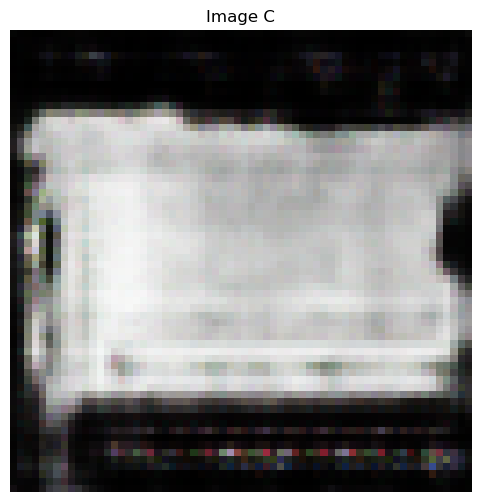

In [ ]:
# l_c = ????
# img_tensor_c = gen(l_c).squeeze(0)
# img_c = TF.to_pil_image(denorm(img_tensor_c).clamp(0, 1))  # Fix: Denormalize before conversion
# plt.figure(figsize=(6,6))
# plt.axis("off")
# plt.title("Image C")
# plt.imshow(img_c, cmap="gray")

#### Latent Space Interpolation

Similarly to performing arithmetic, the same paper demonstrated how you can interpolate between vectors in the latent space. The following few cells, provide possible ways of visualising this interpolation.

We can interpolate between one point in the latent space (the variable `a`) and another point (the variable `b`) to produce a smooth transition between images generated by the GAN along the latent space. 

It is recommended to use a geod "spherical linear interpolation", which effectively describes a ['geodesic'](https://en.wikipedia.org/wiki/Geodesic) ([mini-vid](https://www.youtube.com/watch?v=KsdIuVByfMc)).

See [this discussion](https://github.com/soumith/dcgan.torch/issues/14) and [this post](https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/) for technical details and reference to the interpolation code.

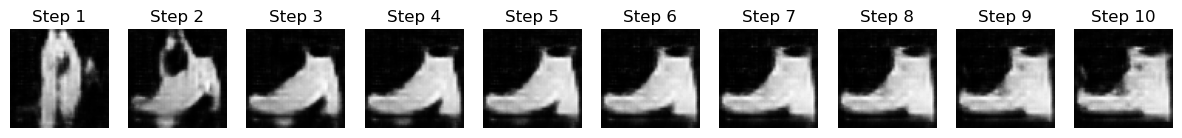

In [22]:
# Linear interpolation
def lerp(t, a, b):
    return a + t * (b - a)

# Spherical linear interpolation
def slerp(val, low, high):
    """Spherical linear interpolation (SLERP) between two latent vectors."""
    low, high = low.astype(np.float32), high.astype(np.float32)  # Ensure float32
    omega = np.arccos(np.clip(np.dot(low / norm(low), high / norm(high)), -1.0, 1.0))
    so = np.sin(omega)
    if so == 0:
        return (1.0 - val) * low + val * high
    return np.sin((1.0 - val) * omega) / so * low + np.sin(val * omega) / so * high

# Number of interpolation steps
num_steps = 10

# Select interpolation method: "lerp" or "slerp"
interpolation_method = "slerp"

# Convert latent vectors to NumPy float32
# Use the already generated latent vectors l_a and l_b
l_a_np = l_a.cpu().numpy().squeeze().astype(np.float32)
l_b_np = l_b.cpu().numpy().squeeze().astype(np.float32)

# Generate interpolated latent vectors
if interpolation_method == "lerp":
    random_latent_vectors = [lerp(t, l_a_np, l_b_np) for t in np.linspace(0, 1, num_steps)]
else:  # Default to SLERP
    random_latent_vectors = [slerp(t, l_a_np, l_b_np) for t in np.linspace(0, 1, num_steps)]

# Prepare figure
fig, axes = plt.subplots(1, num_steps, figsize=(15, 6))

# Generate and display images
for i, latent in enumerate(random_latent_vectors):
    latent = torch.tensor(latent, dtype=torch.float32).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)  # Ensure float32 tensor
    img_tensor = gen(latent).cpu().squeeze(0)  # Move to CPU
    img = TF.to_pil_image((img_tensor * 0.5 + 0.5).clamp(0, 1))  # Fix: Denormalize before conversion
    axes[i].imshow(img, cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"Step {i+1}")

plt.show()


In [23]:
from IPython.display import Video

# Number of interpolation steps
num_steps = 100

# Define video save path
gen_images_dir = pathlib.Path("./gen_images")  # Change if needed
gen_images_dir.mkdir(parents=True, exist_ok=True)  # Ensure directory exists
VIDEO_PATH = gen_images_dir / "interpolation.mp4"

# List to store generated images
img_list = []

# Generate and store images for animation
for latent in random_latent_vectors:
    # Convert to torch tensor, ensure float32
    latent = torch.tensor(latent, dtype=torch.float32).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)
    
    # Generate image from latent vector
    img_tensor = gen(latent).cpu().detach().squeeze(0)  # Fix: Use .detach() to remove gradient tracking
    
    # Convert to NumPy (Denormalize first)
    img = (img_tensor * 0.5 + 0.5).clamp(0, 1).permute(1, 2, 0).numpy()  # Convert to NumPy (H, W, C)
    
    # Store the image
    img_list.append(img)

# Create a figure for animation
fig = plt.figure(figsize=(12, 12))
plt.axis("off")

# Convert images to CPU NumPy format
img_list_cpu = [i for i in img_list]  # Already in NumPy format

# Create animation frames
ims = [[plt.imshow(i, cmap="gray", animated=True)] for i in img_list_cpu]

# Create animation
ani = animation.ArtistAnimation(
    fig, ims, interval=100,  # Speed of animation
    repeat_delay=1000, blit=True
)

# Close figure to avoid displaying static image
plt.close(fig)

# Save animation as an MP4 video
ani.save(str(VIDEO_PATH), writer="ffmpeg", dpi=80)

# Display the video inside Jupyter Notebook
Video(str(VIDEO_PATH), embed=True)


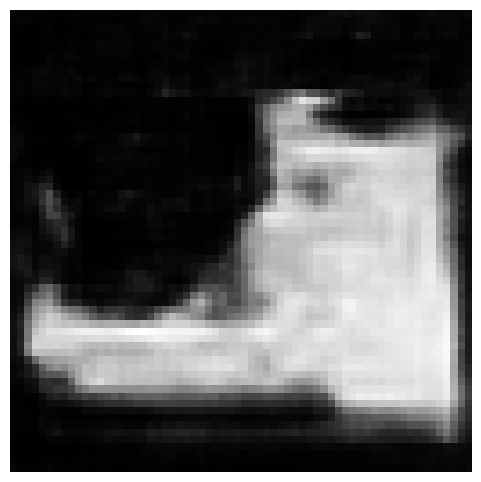

In [24]:
# Number of interpolation steps
num_steps = 100

# Select interpolation method: "lerp" or "slerp"
interpolation_method = "slerp"  # Change to "lerp" if needed

# Convert latent vectors to NumPy float32 to avoid dtype issues
latent_a_np = l_a.cpu().numpy().squeeze().astype(np.float32)
latent_b_np = l_b.cpu().numpy().squeeze().astype(np.float32)

# Generate interpolated latent vectors
if interpolation_method == "lerp":
    random_latent_vectors = [lerp(t, latent_a_np, latent_b_np) for t in np.linspace(0, 1, num_steps, dtype=np.float32)]
else:  # Default to SLERP
    random_latent_vectors = [slerp(t, latent_a_np, latent_b_np) for t in np.linspace(0, 1, num_steps, dtype=np.float32)]

# List to store generated images
img_list = []

# Generate and store images for animation
for latent in random_latent_vectors:
    # Convert to torch tensor, ensure float32
    latent = torch.tensor(latent, dtype=torch.float32).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)
    
    # Generate image from latent vector
    img_tensor = gen(latent).cpu().squeeze(0)  # Move to CPU
    
    # Convert to PIL Image (Denormalize first)
    img = TF.to_pil_image((img_tensor * 0.5 + 0.5).clamp(0, 1))
    
    # Store the image
    img_list.append(img)

# Create the animation
fig = plt.figure(figsize=(6, 6))
plt.axis("off")
imgs = [[plt.imshow(i, cmap="gray", animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, imgs, interval=100, repeat_delay=1000, blit=True)

# Display animation in Jupyter Notebook
HTML(ani.to_jshtml())
